<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_08_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.08 Transformer

* 날짜: 2022.09.06
* 이름: 윤태우

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts/')
import numpy as np
import matplotlib.pyplot as plt

## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [5]:
h = 8 
d_k = 64
d_v  = 64
d_model = 64 * h #512  = embeding dims

# 인풋 x shape 
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max lenth , vocab size )
# 텍스트 임베딩 : (max lenth, embeding dims)

# -> (V, K, Q)
# T = S = max lenth
# d_model = embedding dims
T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [6]:
def matmul(shape1, shape2):
  assert shape1[1]==shape2[0]
  return (shape1[0], shape2[1])
A = (100, 300)
B = (300, 200)
matmul(A, B)

(100, 200)

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [7]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v) 

# calculate shape
VW = matmul(V, W_V) 
KW = matmul(K, W_K) 
QW = matmul(Q, W_Q) 

print(f'Q {Q} x W_Q {W_Q} = {QW}')
print(f'K {K} x W_K {W_K} = {KW}')
print(f'V {V} x W_V {W_V} = {VW}')

Q (200, 512) x W_Q (512, 64) = (200, 64)
K (100, 512) x W_K (512, 64) = (100, 64)
V (100, 512) x W_V (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [8]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW )
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [9]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) {concat_att}')

W_O = ((h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output: {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output: (200, 512)


In [10]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

- 인풋:  (100, 512) (100, 512) (200, 512)
- 최종 아웃풋: (200, 512)


#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [12]:
from tensorflow.keras import layers, utils, models

In [13]:
h = 8 
d_k = 64
d_model = 64 * h #512  = embeding dims

T = 200
S = 100

Q = layers.Input(shape=(T, d_model))
V = layers.Input(shape=(S, d_model))

y = layers.MultiHeadAttention(num_heads = h,
                              key_dim = d_k,
                              )(Q, V)
                          

### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [16]:
def encoder_block(Input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    # multi-head
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(inputs, inputs)
    y = layers.Dropout(dropout)(y)                        
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    y_1 = layers.Add()([y, inputs])

    # Feed Forward Part
    # FF
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = layers.Add()([y, y_1])

    return models.Model(inputs, outputs, name=name)

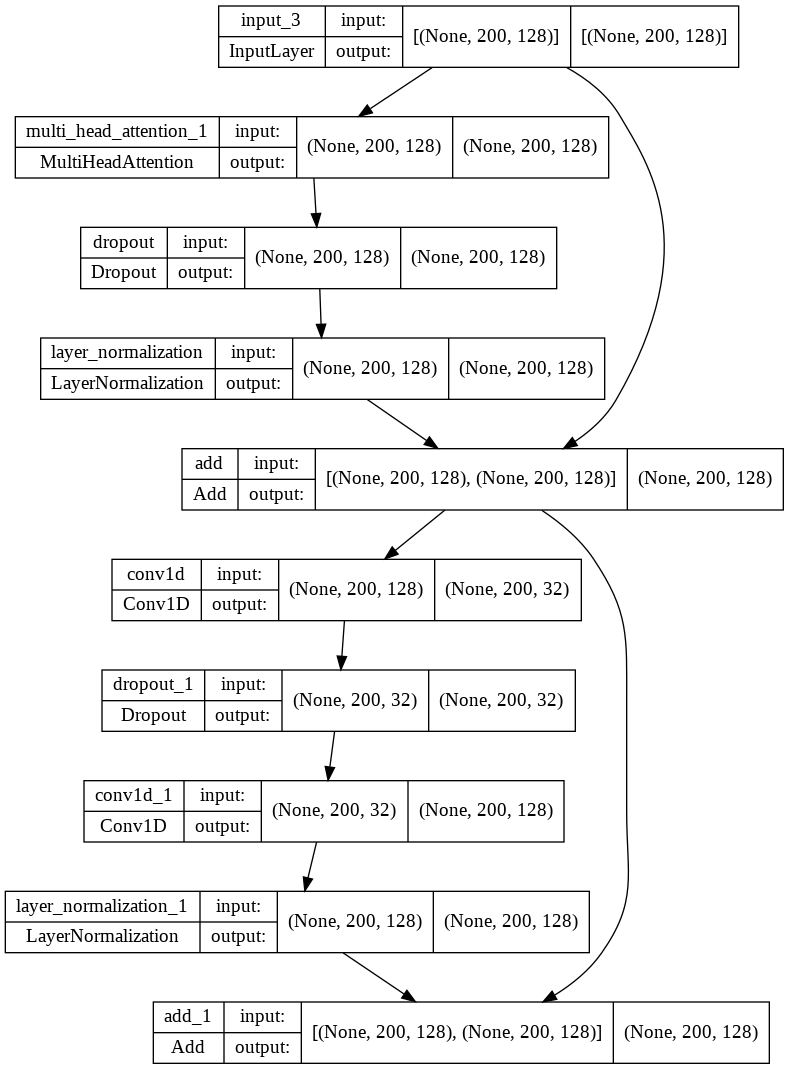

In [17]:
input_shape = (200, 128)
h = 8
d_k = 16
d_ff = 32
encoder = encoder_block(input_shape,
                        h, 
                        d_k, 
                        d_ff)
utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [20]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

(3601, 500, 1) (3601,)


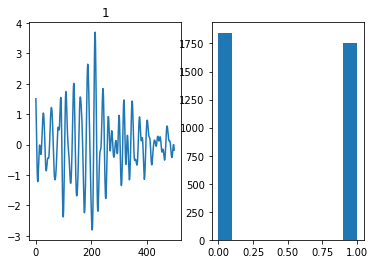

In [23]:
print(x_train.shape, y_train.shape)

idx = 10
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [24]:
### Set params
input_shape = (500, 1) # ( T/S , d_model)
n_classes = 2

N = 4
h = 4
d_k = 128
d_ff = 4

### 모델 구현

# Set Input
inputs = layers.Input(shape=input_shape)

# Encoder Block
y = inputs
for i in range(N):
  encoder = encoder_block(input_shape, 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)

# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 encoder_0 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_1 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_2 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_3 (Functional)      (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d (G  (None, 500)              0         
 lobalAveragePooling1D)                                          
                                             

In [27]:
import tensorflow as tf 

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data=[x_test, y_test],
          epochs = 30,
          batch_size=64,
          callbacks=[es])

Epoch 1/30
57/57 [==============================] - 21s 311ms/step - loss: 1.2328 - acc: 0.5149 - val_loss: 0.8333 - val_acc: 0.5598
Epoch 2/30
57/57 [==============================] - 17s 306ms/step - loss: 0.9373 - acc: 0.5537 - val_loss: 0.6960 - val_acc: 0.6015
Epoch 3/30
57/57 [==============================] - 18s 308ms/step - loss: 0.8581 - acc: 0.5740 - val_loss: 0.6397 - val_acc: 0.6409
Epoch 4/30
57/57 [==============================] - 18s 314ms/step - loss: 0.7799 - acc: 0.6032 - val_loss: 0.6089 - val_acc: 0.6667
Epoch 5/30
57/57 [==============================] - 18s 319ms/step - loss: 0.7356 - acc: 0.6304 - val_loss: 0.5845 - val_acc: 0.6856
Epoch 6/30
57/57 [==============================] - 18s 320ms/step - loss: 0.7029 - acc: 0.6462 - val_loss: 0.5687 - val_acc: 0.7023
Epoch 7/30
57/57 [==============================] - 18s 318ms/step - loss: 0.6670 - acc: 0.6576 - val_loss: 0.5544 - val_acc: 0.7197
Epoch 8/30
57/57 [==============================] - 18s 319ms/step - 

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [ ]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model


### **| 학습**

## 실습3. Vision Transformer
---

In [ ]:
def display_img_patches(img, patches):

  # origin image


  # patches

  # real patches


### **| 이미지 증강**

### **| Patch 생성**

### **| Patch Encoder**


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model
